### 오디오 다운로드

In [ ]:
from predict_stock_outlook import extract_video_audio, predict_market_from_summary_self_consistency

df = pd.read_csv("data_kr/video/자료 수집 최종본.csv")

for row in df.itertuples():
    if pd.isna(row.url) or row.url == '' or row.category != "video":
        continue

    code = str(row.code).zfill(6)
    audio_dir = f'data_kr/video/audio/{row.sector}/{code}/'
    text_dir = f'data_kr/video/text/{row.sector}/{code}/'
    os.makedirs(audio_dir, exist_ok=True)

    if audio_dir + f'{row.year}-{row.quarter}' != 'data_kr/video/audio/산업재/003490/2016-Q2':
        continue
    
    if extract_video_audio("link", row.url, audio_dir + f'{row.year}-{row.quarter}'):
        with open('data_kr/video/log.txt', "a", encoding="utf-8") as log_file:
            timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
            log_file.write(f"{timestamp} audio download completed: {audio_dir + f'{row.year}-{row.quarter}'}\n")
    else:
        with open('data_kr/video/log.txt', "a", encoding="utf-8") as log_file:
            timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
            log_file.write(f"{timestamp} audio download error: {audio_dir + f'{row.year}-{row.quarter}'}\n")

### 텍스트로 변환

In [ ]:
from predict_stock_outlook import audio2text

df = pd.read_csv("data_kr/video/자료 수집 최종본.csv")

for row in df.itertuples():
    if pd.isna(row.url) or row.url == '' or row.category != "video":
        continue

    code = str(row.code).zfill(6)
    audio_dir = f'data_kr/video/audio/{row.sector}/{code}/'
    text_dir = f'data_kr/video/text/{row.sector}/{code}/'
    os.makedirs(text_dir, exist_ok=True)
    
    if audio_dir + f'{row.year}-{row.quarter}' != 'data_kr/video/audio/산업재/003490/2016-Q2':
        continue
    
    try:
        text = audio2text(audio_dir + f'{row.year}-{row.quarter}')
        with open(text_dir + f'{row.year}-{row.quarter}.txt', "w", encoding="utf-8") as f:
            f.write(text)
        with open('data_kr/video/log.txt', "a", encoding="utf-8") as log_file:
            timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
            log_file.write(f"{timestamp} whisper completed: {text_dir + f'{row.year}-{row.quarter}'}\n")
    except Exception as e:
        with open('data_kr/video/log.txt', "a", encoding="utf-8") as log_file:
            timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
            log_file.write(f"{timestamp} whisper error: {text_dir + f'{row.year}-{row.quarter}'}\n")

### 텍스트 token 수 확인

In [ ]:
df = pd.read_csv("data_kr/video/자료 수집 최종본.csv")

import tiktoken
# 예: GPT-4용 인코더 불러오기
encoding = tiktoken.encoding_for_model("gpt-4o")
total_tokens = 0

for row in tqdm(df.itertuples(), total=len(df), desc="checking tokens"):
	if pd.isna(row.url) or row.url == '':
		continue

	code = str(row.code).zfill(6)
	text_dir = f'data_kr/video/text/{row.sector}/{code}/'
	os.makedirs(text_dir, exist_ok=True)
    
	try:
		filename = f'{row.year}-{row.quarter}-{str(row.month).zfill(2)}-{row.week}.txt'
		with open(text_dir + filename, "r", encoding="utf-8") as file:
			text = file.read()
			system_prompt = """
		너는 경제 전문 뉴스 분석 AI야. 사용자가 지정한 종목(회사명)과 직접적으로 관련된 정보만 선택해 핵심적으로 요약해.
		사실 기반으로 요약하고, 감성이나 추론이 필요한 경우에는 중립적으로 표현해.
		"""

			user_prompt = f"""
		다음은 경제 뉴스 기사입니다.

		이 기사에서 **한국 상장 기업 "{code}"**과 관련된 내용만 골라 요약해 주세요.

		요약 기준:
		- "{code}"이 언급된 부분 중심
		- 관련 사업, 실적, 주가, 시장 반응, 경쟁사와의 연관성
		- 정부 정책, 산업 트렌드 등 외부 요인 중 관련 있는 부분
		- 부정적/긍정적 논조도 간단히 언급 (있는 경우)

		형식은 간결한 문장 또는 Bullet Point 형식으로 작성해 주세요.

		기사 전문:
		{text}
		"""
			total_prompt = system_prompt + user_prompt
			tokens = encoding.encode(total_prompt)
			total_tokens += len(tokens)
		with open('data_kr/video/num_token.txt', "a", encoding="utf-8") as log_file:
			timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
			log_file.write(f"{text_dir}{filename} len: {len(text)}, token: {len(tokens)}\n")
	except Exception as e:
		with open('data_kr/video/num_token.txt', "a", encoding="utf-8") as log_file:
			timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
			log_file.write(f"{text_dir}{filename} error: " + e + "\n")

with open('data_kr/video/num_token.txt', "a", encoding="utf-8") as log_file:
	log_file.write(f"total tokens: {total_tokens}\n")

### LLM으로 요약

In [ ]:
from predict_stock_outlook import summarize_text

df = pd.read_csv("data_kr/video/자료 수집 최종본.csv")

for row in tqdm(df.itertuples(), total=len(df), desc="LLM summarizing"):
    if pd.isna(row.url) or row.url == '':
        continue

    code = str(row.code).zfill(6)
    name = row.name
    text_dir = f'data_kr/video/text/{row.sector}/{code}/'
    summary_dir = f'preprocessed_data/llm/summary/{row.sector}/{code}/'
    os.makedirs(summary_dir, exist_ok=True)
        
    try:
        filename = f'{row.year}-{row.quarter}-{str(row.month).zfill(2)}-{row.week}.txt'
        stock = f'{name}({code})'
        with open(text_dir + filename, "r", encoding="utf-8") as file:
            text = file.read()
        summary = summarize_text(text, stock)
        with open(summary_dir + filename, "w", encoding="utf-8") as f:
            f.write(summary)
        with open('preprocessed_data/llm/summary/log.txt', "a", encoding="utf-8") as log_file:
            timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
            log_file.write(f"{timestamp} summary completed: {summary_dir + filename}\n")
    except Exception as e:
        with open('preprocessed_data/llm/summary/log.txt', "a", encoding="utf-8") as log_file:
            timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
            log_file.write(f"{timestamp} summary error: {summary_dir + filename}\t error: {e}\n")

### LLM으로 기사 자막요약을 통해 등락 예측

In [ ]:
from predict_stock_outlook import predict_market_from_summary
from predict_stock_outlook import predict_market_from_summary_self_consistency
import os
from tqdm import tqdm
from datetime import datetime
import pandas as pd

df = pd.read_csv('data_kr/video/뉴스 기사 수집본.csv', encoding='utf-8')
llm_dir = 'predict_text_gem' # preprocessed_data/llm/ 하위폴더명 (llm predict 저장될 곳)

for code in df["code"].unique():
    df_ = df[df["code"] == code].reset_index(drop=True)
    
    for row in tqdm(df_.itertuples(), total=len(df_), desc=f"{code}LLM predicting"):
        if pd.isna(row.url) or row.url == '':
            continue
        
        code = str(row.code).zfill(6)
        name = row.name
        article_dir = f'data_kr/video/text/{row.sector}/{code}/'
        predict_dir = f'preprocessed_data/llm/{llm_dir}/{row.sector}/{code}/'
        os.makedirs(predict_dir, exist_ok=True)

        try:
            filename = f'{row.year}-{row.quarter}-{str(row.month).zfill(2)}-{row.week}.txt'
            stock = f'{name}({code})'
            with open(f'{article_dir}{filename}', "r", encoding="utf-8") as file:
                article = file.read()
            data = predict_market_from_summary_self_consistency(article, f'{name}({code})')
            
            with open(f'{predict_dir}{filename}', "w", encoding="utf-8") as file:
                file.write(data)
            
            with open(f'preprocessed_data/llm/{llm_dir}/log.txt', "a", encoding="utf-8") as log_file:
                timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
                log_file.write(f"{timestamp} predict completed: {predict_dir}{filename}\n")
        except Exception as e:
            with open(f'preprocessed_data/llm/{llm_dir}/log.txt', "a", encoding="utf-8") as log_file:
                timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
                log_file.write(f"{timestamp} predict error: {predict_dir}{filename}\n")
                print(e)

120LLM predicting:   0%|          | 1/204 [00:06<23:29,  6.94s/it]

### LLM으로 영상 자막요약을 통해 등락 예측

In [12]:
from predict_stock_outlook import predict_market_from_summary
import os
from tqdm import tqdm
from datetime import datetime
import pandas as pd

df = pd.read_csv('data_kr/video/뉴스 영상 수집본.csv', encoding='utf-8')
llm_dir = 'predict_video_gem' # preprocessed_data/llm/ 하위폴더명 (llm predict 저장될 곳)

for code in df["code"].unique():
    df_ = df[df["code"] == code].reset_index(drop=True)

    for row in tqdm(df_.itertuples(), total=len(df_), desc=f"{code}LLM predicting"):
        if pd.isna(row.url) or row.url == '':
            continue
        
        code = str(row.code).zfill(6)	
        name = row.name
        script_dir = f'data_kr/video/script/{row.sector}/{code}/'
        predict_dir = f'preprocessed_data/llm/{llm_dir}/{row.sector}/{code}/'
        os.makedirs(predict_dir, exist_ok=True)

        try:
            filename = f'{row.year}-{row.quarter}-{str(row.month).zfill(2)}-{row.week}.txt'
            stock = f'{name}({code})'
            with open(f'{script_dir}{filename}', "r", encoding="utf-8") as file:
                script = file.read()
            prediction = predict_market_from_summary(script, f'{name}({code})')
            
            with open(f'{predict_dir}{filename}', "w", encoding="utf-8") as file:
                file.write(prediction)
            
            with open(f'preprocessed_data/llm/{llm_dir}/log.txt', "a", encoding="utf-8") as log_file:
                timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
                log_file.write(f"{timestamp} predict completed: {predict_dir}{filename}\n")
        except Exception as e:
            with open(f'preprocessed_data/llm/{llm_dir}/log.txt', "a", encoding="utf-8") as log_file:
                timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
                log_file.write(f"{timestamp} predict error: {predict_dir}{filename}\n")  

120LLM predicting:  14%|█▎        | 28/204 [00:05<00:34,  5.10it/s]


KeyboardInterrupt: 

### LLM으로 영상자막요약 + 기사자막요약을 통해 등락 예측

In [ ]:
from predict_stock_outlook import predict_market_from_mix
import os
from tqdm import tqdm
from datetime import datetime
import pandas as pd

llm_dir = 'predict_mix_gem' # preprocessed_data/llm/ 하위폴더명 (llm predict 저장될 곳)

df_v = pd.read_csv('data_kr/video/뉴스 영상 수집본.csv', encoding='utf-8')
df_v.rename(columns={'url':'v_url', 'upload_dt':'v_upload_dt'}, inplace=True)
df_v = df_v[["year","quarter","month","week","code","name","sector","after","before","v_url","v_upload_dt"]]

df_a = pd.read_csv('data_kr/video/뉴스 기사 수집본.csv', encoding='utf-8')
df_a.rename(columns={'url':'a_url', 'upload_dt':'a_upload_dt'}, inplace=True)
df_a = df_a[["a_url","a_upload_dt"]]

df = pd.concat([df_v, df_a], axis=1)

for code in df["code"].unique():
    df_ = df[df["code"] == code].reset_index(drop=True)

    for row in tqdm(df_.itertuples(), total=len(df_), desc=f"{code}LLM predicting"):
        if pd.isna(row.v_url) or pd.isna(row.a_url) :
            continue
        
        code = str(row.code).zfill(6)
        name = row.name
        v_summary_dir = f'data_kr/video/script/{row.sector}/{code}/'
        t_summary_dir = f'data_kr/video/text/{row.sector}/{code}/'
        predict_dir = f'preprocessed_data/llm/{llm_dir}/{row.sector}/{code}/'
        os.makedirs(predict_dir, exist_ok=True)

        try:
            filename = f'{row.year}-{row.quarter}-{str(row.month).zfill(2)}-{row.week}.txt'
            stock = f'{name}({code})'
            with open(f'{v_summary_dir}{filename}', "r", encoding="utf-8") as file:
                script = file.read()
            with open(f'{t_summary_dir}{filename}', "r", encoding="utf-8") as file:
                article = file.read()
 
            data = predict_market_from_mix(article, script, f'{name}({code})')
            
            with open(f'{predict_dir}{filename}', "w", encoding="utf-8") as file:
                file.write(data)
            
            with open(f'preprocessed_data/llm/{llm_dir}/log.txt', "a", encoding="utf-8") as log_file:
                timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
                log_file.write(f"{timestamp} predict completed: {predict_dir}{filename}\n")
        except Exception as e:
            with open(f'preprocessed_data/llm/{llm_dir}/log.txt', "a", encoding="utf-8") as log_file:
                timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
                log_file.write(f"{timestamp} predict error: {predict_dir}{filename}\n")

### 기사 예측 결과 정리

In [32]:
import json
import os
from tqdm import tqdm
from datetime import datetime
import pandas as pd

llm_dir = 'predict_text_gem' # preprocessed_data/llm/ 하위폴더명 (llm predict 저장될 곳)

df=pd.read_csv('./data_kr/video/뉴스 기사 수집본.csv', encoding='utf-8')

for code in df["code"].unique():
    df_ = df[df["code"] == code].reset_index(drop=True)
    score_list = []

    for row in tqdm(df_.itertuples(), total=len(df_), desc=f"{code}LLM predicting"):
        if pd.isna(row.url) or row.url == '':
            score_list.append(None)
            continue
        
        code = str(row.code).zfill(6)	
        name = row.name
        predict_dir = f'preprocessed_data/llm/{llm_dir}/{row.sector}/{code}/'
        os.makedirs(predict_dir, exist_ok=True)

        try:
            filename = f'{row.year}-{row.quarter}-{str(row.month).zfill(2)}-{row.week}.txt'
 
            with open(f'{predict_dir}{filename}', 'r', encoding='utf-8') as f:
                # json.load() 함수를 사용하여 파일의 내용을 파이썬 딕셔너리로 불러옵니다.
                score = int(f.read())

            score_list.append(score)
            
        except Exception as e:
            print(f'error: {e}, file:{filename}')
            score_list.append(0)
            
    df_predict = df_.copy()
    df_predict["score"] = score_list
    df_predict = df_predict[["year", "quarter", "month", "week", "code", "name", "sector", "upload_dt", "score"]]
    df_predict.to_csv(f"{predict_dir}{code}.csv", index=False, encoding="utf-8")

86280LLM predicting: 100%|█████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 7480.86it/s]


### 영상 예측 결과 정리

In [33]:
import json
import os
from tqdm import tqdm
from datetime import datetime
import pandas as pd

llm_dir = 'predict_video_gem' # preprocessed_data/llm/ 하위폴더명 (llm predict 저장될 곳)

df = pd.read_csv('./data_kr/video/뉴스 영상 수집본.csv', encoding='utf-8')

for code in df["code"].unique():
    df_ = df[df["code"] == code].reset_index(drop=True)
    score_list = []
    
    for row in tqdm(df_.itertuples(), total=len(df_), desc=f"{code}LLM predicting"):
        if pd.isna(row.url) or row.url == '':
            score_list.append(None)
            continue
        
        code = str(row.code).zfill(6)	
        name = row.name
        predict_dir = f'preprocessed_data/llm/{llm_dir}/{row.sector}/{code}/'
        os.makedirs(predict_dir, exist_ok=True)

        try:
            filename = f'{row.year}-{row.quarter}-{str(row.month).zfill(2)}-{row.week}.txt'
 
            with open(f'{predict_dir}{filename}', 'r', encoding='utf-8') as f:
                # json.load() 함수를 사용하여 파일의 내용을 파이썬 딕셔너리로 불러옵니다.
                score = int(f.read())

            score_list.append(score)
            
        except Exception as e:
            print(f'error: {e}, file:{filename}')
            score_list.append(0)
            
    df_predict = df_.copy()
    df_predict["score"] = score_list
    df_predict = df_predict[["year", "quarter", "month", "week", "code", "name", "sector", "upload_dt", "score"]]
    df_predict.to_csv(f"{predict_dir}{code}.csv", index=False, encoding="utf-8")

86280LLM predicting: 100%|█████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 9483.80it/s]


### 영상+기사 예측 결과 정리

In [34]:
from predict_stock_outlook import predict_market_from_mix
import os
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np

llm_dir = 'predict_mix_gem' # preprocessed_data/llm/ 하위폴더명 (llm predict 저장될 곳)

df_v = pd.read_csv('data_kr/video/뉴스 영상 수집본.csv', encoding='utf-8')
df_v.rename(columns={'url':'v_url', 'upload_dt':'v_upload_dt'}, inplace=True)
df_v = df_v[["year","quarter","month","week","code","name","sector","after","before","v_url","v_upload_dt"]]

df_a = pd.read_csv('data_kr/video/뉴스 기사 수집본.csv', encoding='utf-8')
df_a.rename(columns={'url':'a_url', 'upload_dt':'a_upload_dt'}, inplace=True)
df_a = df_a[["a_url","a_upload_dt"]]

df = pd.concat([df_v, df_a], axis=1)

for code in df["code"].unique():
    df_ = df[df["code"] == code].reset_index(drop=True)
    score_list = []
    uploaddt_list = []

    for row in tqdm(df_.itertuples(), total=len(df_), desc=f"{code}LLM predicting"):
        if pd.isna(row.v_url) or pd.isna(row.a_url) :
            score_list.append(None)
            uploaddt_list.append(None)
            continue
        
        code = str(row.code).zfill(6)
        name = row.name
        predict_dir = f'preprocessed_data/llm/{llm_dir}/{row.sector}/{code}/'
        os.makedirs(predict_dir, exist_ok=True)

        try:
            filename = f'{row.year}-{row.quarter}-{str(row.month).zfill(2)}-{row.week}.txt'
            
            with open(f'{predict_dir}{filename}', 'r', encoding='utf-8') as f:
                # json.load() 함수를 사용하여 파일의 내용을 파이썬 딕셔너리로 불러옵니다.
                score = int(f.read().splitlines()[0])

            score_list.append(score)
            if not pd.isna(row.v_upload_dt) and not pd.isna(row.a_upload_dt):
                uploaddt = row.v_upload_dt if row.v_upload_dt > row.a_upload_dt else row.a_upload_dt
                uploaddt_list.append(uploaddt)
            else:
                uploaddt_list.append(None)
                
            
        except Exception as e:
            print(f'error: {e}, file:{filename}')
            score_list.append(0)
            
            
    df_predict = df_.copy()
    df_predict["score"] = score_list
    df_predict['upload_dt'] = uploaddt_list
    df_predict = df_predict[["year", "quarter", "month", "week", "code", "name", "sector", "upload_dt", "score"]]
    df_predict.to_csv(f"{predict_dir}{code}.csv", index=False, encoding="utf-8")

86280LLM predicting: 100%|████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 13503.11it/s]


## 예측 결과 정리 concat

In [35]:
from pathlib import Path
import pandas as pd
# 현재 폴더를 Path 객체로 만듭니다.
datas=['video', 'text', 'mix']
llm_dirs=[f'predict_{data}_gem' for data in datas]

for data, llm_dir in zip(datas, llm_dirs):
    path_list = []
    for sector in ["산업재", "정보기술"]:
        root_path = Path(f'./preprocessed_data/llm/{llm_dir}/{sector}')
        
        # rglob('*')는 재귀적으로 모든(*) 파일과 폴더를 찾습니다.
        for path in root_path.rglob('*.csv'):
            # path는 파일 또는 폴더에 대한 Path 객체입니다.
            path_list.append(path)
    df_list = [pd.read_csv(f'{path}', encoding='utf-8') for path in path_list]
    df = pd.concat(df_list, axis=0)
    df = df.sort_values(by=['code', 'year', 'quarter', 'month', 'week'], ascending=True)
    df.to_csv(f'./preprocessed_data/llm/{llm_dir}/predict.csv', index=False, encoding='utf-8')
    df.to_csv(f'./preprocessed_data/llm/predict_total/{llm_dir}.csv', index=False, encoding='utf-8')

## mix에 video or text 단독예측도 추가하여 predict_total 생성

In [36]:
import pandas as pd

## 파일경로 알아서 바꾸기

df_v = pd.read_csv('preprocessed_data/llm/predict_total/predict_video_gem.csv', encoding='utf-8')
df_t = pd.read_csv('preprocessed_data/llm/predict_total/predict_text_gem.csv', encoding='utf-8')
df_m = pd.read_csv('preprocessed_data/llm/predict_total/predict_mix_gem.csv', encoding='utf-8')

df_total = df_m.copy()
df_total[pd.isna(df_total)] = df_v[pd.isna(df_total)]
df_total[pd.isna(df_total)] = df_t[pd.isna(df_total)]

df_total.to_csv('preprocessed_data/llm/predict_total/predict_total_gem.csv', index=False, encoding='utf-8')

### 자료 수집 긍정/중립/부정/결측치 비율 측정

In [56]:
import pandas as pd 

directory = './preprocessed_data/llm/predict_total_CoT'

df_v = pd.read_csv(f'{directory}/predict_video_CoT.csv', encoding='utf-8') 
df_a = pd.read_csv(f'{directory}/predict_text_CoT.csv', encoding='utf-8') 
df_m = pd.read_csv(f'{directory}/predict_mix_CoT.csv', encoding='utf-8') 
df_t = pd.read_csv(f'{directory}/predict_total_CoT.csv', encoding='utf-8') 

df_list = [df_v, df_a, df_m, df_t] 
names = ['video', 'article', 'mix', 'total'] 

df_ratio = {} 
for df, name in zip(df_list, names): 
    df_ = {} 
    nan_list = pd.isna(df['score']) 
    nan_num = sum(nan_list) 
    total_num = len(df) 
    df_['결측'] = f'{(nan_num / total_num * 100):.2f}%' 
     
    up_list = (df['score'] == 1.0) 
    up_num = sum(up_list) 
    # total_num은 루프 내에서 반복적으로 계산할 필요가 없습니다.
    df_['상승'] = f'{(up_num / total_num * 100):.2f}%' 
     
    middle_list = (df['score'] == 0.0) 
    # 'middel_num' -> 'middle_num' 오타 수정
    middle_num = sum(middle_list) 
    df_['중립'] = f'{(middle_num / total_num * 100):.2f}%' 
     
    down_list = (df['score'] == -1.0) 
    down_num = sum(down_list) 
    df_['하락'] = f'{(down_num / total_num * 100):.2f}%' 
     
    df_ratio[name] = df_ 

# DataFrame을 생성한 후 .T를 붙여 행과 열을 전환합니다.
pd.DataFrame(df_ratio).to_csv(f'{directory}/predict_ratio_CoT.csv', encoding='utf-8')

## LLM 정확도 측정 (업로드일 전후 가격 비교) & 정확도 지표

In [55]:
from datetime import timedelta, datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def get_pred_accuracy():
    scores = dict()
    
    plt.figure(figsize=(24, 5))
    
    datas = ['video', 'article', 'mix', 'total']
    directory = './preprocessed_data/llm/predict_total_CoT'
    llm_dirs=[
        'predict_video_CoT',
        'predict_text_CoT',
        'predict_mix_CoT',
        'predict_total_CoT',
    ]
    plot_dir='predict_accuracy_after1_CoT'
    for idx, (data, llm_dir) in enumerate(zip(datas, llm_dirs)):
        df = pd.read_csv(f'{directory}/{llm_dir}.csv', encoding='utf-8')
        df_d = pd.read_csv(f'data_kr/video/뉴스 기사 수집본.csv', encoding='utf-8')[['after', 'before']]
        df = pd.concat([df, df_d], axis=1)
        df[['upload_dt', 'after', 'before']] = df[['upload_dt', 'after', 'before']].apply(pd.to_datetime)
        
        ### LLM 예측에 실제 등락 라벨 추가 ###
        df["code"] = df["code"].astype(str).str.zfill(6)
        
        price_upload = [] # 업로드 당일 종가
        price_end = [] # 공시 당일 종가
        for row in tqdm(df.itertuples(), total=len(df)):
            df_price = pd.read_csv(f"data_kr/price/{row.code}.csv")
            df_price['날짜'] = pd.to_datetime(df_price['날짜'])
            ### 업로드 날짜 직전 종가
            price_upload.append(df_price.loc[df_price["날짜"] < row.upload_dt, "종가"].iloc[-1] if not pd.isna(row.upload_dt) else None)
            ### 데이터 업로드 다음 날 종가
            price_end.append(df_price.loc[df_price["날짜"] > row.upload_dt, "종가"].iloc[0] if not pd.isna(row.upload_dt) else None)
        
        df["price_upload"] = price_upload
        df["price_end"] = price_end
    
        def check_change(row):
            rate = (row["price_end"] / row["price_upload"] - 1) * 100
            if rate > 0:
                return "상승"
            else:
                return "하락"
        df["label"] = df.apply(check_change, axis=1)

        ###############################################################
        ### 유효한 데이터만 남기기 ###
        valid_bool = ~(pd.isna(df['score']) | (df['score'] == 0))
        prediction = df[valid_bool]['score']
        label = df[valid_bool]['label']
        
        mapping = {1: '상승', 0: '하락', -1: '하락'}
        prediction = [mapping[l] for l in prediction]

        accuracy = accuracy_score(label, prediction)
        precision = precision_score(label, prediction, pos_label='상승', zero_division=0)
        recall = recall_score(label, prediction, pos_label='상승', zero_division=0)
        f1 = f1_score(label, prediction, pos_label='상승', zero_division=0)

        score_dict = {'accuracy': accuracy, 'precision':precision, 'recall':recall, 'f1':f1}
        scores[data] = score_dict
        
        # 혼동 행렬
        labels = ["상승", "하락"]
        cm = confusion_matrix(label, prediction, labels=labels)
        
        # 한글 폰트 설정 (Windows, Mac, Linux 환경에 맞게 설정)
        # 윈도우
        plt.rc('font', family='Malgun Gothic')
    
        # 시각화
        plt.subplot(1, 4, idx + 1)  # 1행 3열 중 i번째 위치에 subplot을 생성
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title(f'{data} Accuracy Confusion Matrix')
        
    plt.tight_layout()
    plt.savefig(f"{directory}/{plot_dir}.png")
    plt.close()
    pd.DataFrame(scores).to_csv(f"{directory}/{plot_dir}.csv")

get_pred_accuracy()

100%|█████████████████████████████████████████████████████████████████████████████| 5712/5712 [00:25<00:00, 225.58it/s]


## LLM 예측 가중합 정확도 측정 (ROC curve)

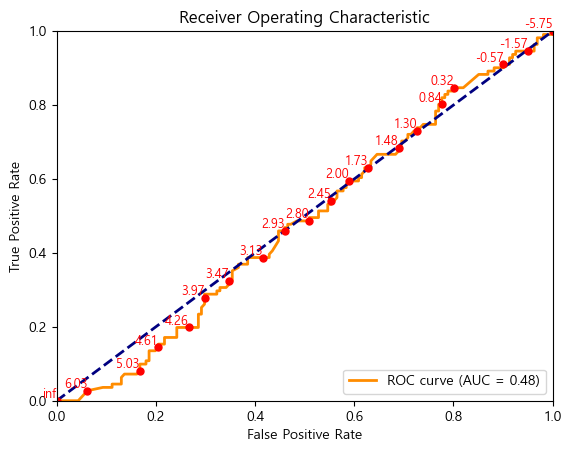

pred: [4.258064516129032, -2.2903225806451615, 0.0, 1.3548387096774195, 3.466666666666667, 1.0322580645161288, 4.483870967741936, 5.9655172413793105, 2.6129032258064515, -0.19999999999999996, 0.966666666666667, 2.3870967741935485, 5.903225806451613, 2.966666666666667, 1.4285714285714286, -0.482758620689655, 2.129032258064516, 1.5, 3.967741935483871, 1.6333333333333333, 6.032258064516129, -1.9, 5.903225806451613, 5.870967741935484, 2.612903225806452, 1.5806451612903225, 1.967741935483871, 0.43333333333333335, 6.033333333333333, 6.0, 5.933333333333334, 5.903225806451613, 2.387096774193548, 1.8928571428571428, 0.3666666666666667, 4.870967741935484, 2.838709677419355, 0.5806451612903225, -0.5666666666666667, 3.5161290322580645, 3.033333333333333, -0.5161290322580645, 6.0, -0.3666666666666667, 1.7333333333333334, 0.0, 3.3870967741935485, 3.129032258064516, 1.8666666666666667, 1.2903225806451613, -0.46666666666666656, 3.32258064516129, 3.0, 1.4838709677419353, 1.838709677419355, 3.1071428571

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import calendar
from datetime import datetime, timedelta
import pandas as pd

df = pd.read_csv("./preprocessed_data/llm/predict_total_CoT/predict_text_CoT.csv", encoding='utf-8')
df['upload_dt'] = pd.to_datetime(df['upload_dt'])
df['code'] = df['code'].astype(str).str.zfill(6)

pred = []
label = []
for idx in range(0, len(df), 4):
    df_ = df.iloc[idx:idx+4].copy()

    ########### score 가중합 구하기 ############
    year, month = df_.loc[idx, ['year', 'month']]
    _, num_days = calendar.monthrange(year, month)

    upload_start = datetime(year, month, 1)
    upload_end = datetime(year, month, num_days)

    # 'Series' 전체에 .days를 적용할 수 없으므로 .dt 접근자 사용
    df_["score"] *= 1 + ((df_['upload_dt'] - upload_start).dt.days + 1) / num_days
    weighted_sum = sum(df_['score'])

    if pd.isna(weighted_sum): continue
    else: pred.append(weighted_sum)

    ########### label 구하기 ############
    next_year, next_month = (year, month + 1) if month != 12 else (year + 1, 1)
    _, num_days = calendar.monthrange(next_year, next_month)
    buy_date = datetime(next_year, next_month, 1)
    sell_date = datetime(next_year, next_month, num_days)

    df_price = pd.read_csv(f"data_kr/price/{df_.loc[idx, 'code']}.csv")
    df_price['날짜'] = pd.to_datetime(df_price['날짜'])
    ### buy_date 직후 종가
    buy_price = df_price.loc[df_price["날짜"] >= buy_date, "종가"].iloc[0]
    ### sell_date 직전 종가
    sell_price = df_price.loc[df_price["날짜"] <= sell_date, "종가"].iloc[-1]


    if sell_price - buy_price > 0: label.append(1) # 주가 상승
    else: label.append(-1) # 주가 하락

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(label, pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# threshold 점 찍기
num_thresholds_to_show = 20
indices_to_show = np.linspace(0, len(thresholds) - 1, num_thresholds_to_show).astype(int)

for i in indices_to_show:
    threshold_value = thresholds[i]
    fpr_point = fpr[i]
    tpr_point = tpr[i]

    # 임계값을 그래프 위에 텍스트로 표시
    # text() 함수의 x, y 좌표는 데이터 좌표계입니다.
    # ha='center', va='bottom'은 텍스트 정렬을 지정합니다.
    # round() 함수를 사용하여 소수점 자릿수를 조정합니다.
    plt.text(fpr_point, tpr_point,
             f'{threshold_value:.2f}',
             color='red', fontsize=9, ha='right', va='bottom')
    # 선택된 임계값 지점에 작은 마커를 추가하여 시각적으로 강조
    plt.plot(fpr_point, tpr_point, 'o', color='red', markersize=5)


plt.savefig('ROC.png')
plt.show()

print(f'pred: {pred}')
print(f'label: {label}')
print(f'fpr: {fpr}')
print(f'tpr: {tpr}')
print(f'thresholds: {thresholds}')

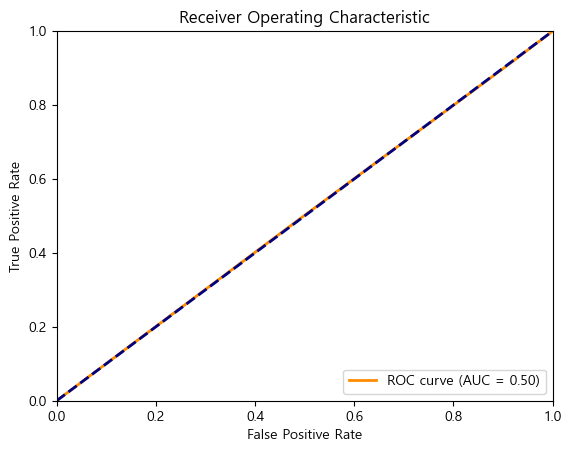

pred: [-1, 0, 0, 1, 0, 1, 1, 1, 0, 0, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 0, -1, -1, 1, 1, 1, 1, 0, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, -1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, -1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, -1, 1, 1, 1, 1, 1, -1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, -1, 1, 1, 0, 1, 1, 1, 1, -1, 1, 0, -1, 0, 1, 0, 0, 0, 0, 1, -1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, -1, 0, -1, 1, -1, 0, 1, -1, 0, 1, 1, 0, 1, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, -1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, -1, 0, -1, 1, 1, 1, 0, -1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 0, 1, 1

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import calendar
from datetime import datetime, timedelta
import pandas as pd

df = pd.read_csv("./preprocessed_data/llm/predict_total_CoT/predict_text_CoT.csv", encoding='utf-8')
df['upload_dt'] = pd.to_datetime(df['upload_dt'])
df['code'] = df['code'].astype(str).str.zfill(6)

pred = []
label = []

df = df[df['score'].notna()]
pred = df['score'].astype(int).to_list()
########### label 구하기 ############
for row in df.itertuples():
    next_year = row.year + 1 if (row.month==12 and row.week==4) else row.year
    next_month = row.month + 1 if (row.month<12 and row.week==4) else (row.month if row.week<4 else 1)
    next_week = row.week + 1 if row.week < 4 else 1
    _, num_days = calendar.monthrange(next_year, next_month)
    day_map = {1: [1,7], 2:[8,14], 3:[15,21], 4:[22,num_days]}
    
    buy_date = datetime(next_year, next_month, day_map[next_week][0])
    sell_date = datetime(next_year, next_month, day_map[next_week][1])
    
    df_price = pd.read_csv(f"data_kr/price/{df_.loc[idx, 'code']}.csv")
    df_price['날짜'] = pd.to_datetime(df_price['날짜'])
    ### buy_date 직후 종가
    buy_price = df_price.loc[df_price["날짜"] >= buy_date, "종가"].iloc[0]
    ### sell_date 직전 종가
    sell_price = df_price.loc[df_price["날짜"] <= sell_date, "종가"].iloc[-1]
    
    
    if sell_price - buy_price > 0: label.append(1) # 주가 상승
    else: label.append(0) # 주가 하락

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(label, pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print(f'pred: {pred}')
print(f'label: {label}')
print(f'fpr: {fpr}')
print(f'tpr: {tpr}')
print(f'thresholds: {thresholds}')